In [1]:
import tensorflow as tf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from tensorflow.examples.tutorials.mnist import input_data

%config InlineBackend.figure_format = 'svg'
learning_rate = 0.01
epochs = 1000
n_samples = 3500
cost_history = np.empty(shape=[1],dtype=float)
INPUT_DIMENSIONS = 784


# HELPER FUNCTIONS

def get_batch(size, data, target): 
    index = np.arange(0, len(data))
    np.random.shuffle(index)
    index = index[:size]
    batch_data =  [data[ i] for i in index]
    batch_target = [target[ i] for i in index]
    return np.asarray(batch_data), np.asarray(batch_target)

def shuffle(data, target):
    index = np.arange(0, len(data))
    np.random.shuffle(index)
    shuffled_data = [data[i] for i in index]
    shuffled_target = [target[i] for i in index]
    return np.asarray(shuffled_data), np.asarray(shuffled_target)

_,accuracy [0.0, 0.95]
[0.95]
_,accuracy [0.0, 0.94482756]
[0.94482756]
_,accuracy [0.0, 0.9597143]
[0.9597143]


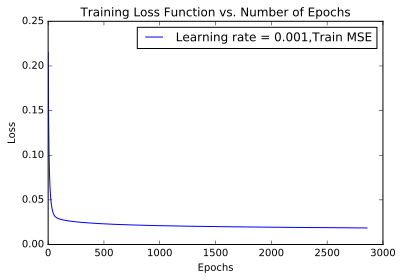

In [2]:
def train_and_run_linear_reg(num_epochs, batch_size, p_learning_rate, decay_coefficient, test_set):
    epochs = num_epochs
    BATCH_SIZE = batch_size 
    learning_rate = p_learning_rate
    beta = decay_coefficient
    train_accuracy_log = np.zeros(epochs+1)

    
    with np.load("notMNIST.npz") as data :
        Data, Target = data ["images"], data["labels"]
        posClass = 2
        negClass = 9
        dataIndx = (Target==posClass) + (Target==negClass)
        Data = Data[dataIndx]/255.
        Target = Target[dataIndx].reshape(-1, 1)
        Target[Target==posClass] = 1
        Target[Target==negClass] = 0
        np.random.seed(521)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data, Target = Data[randIndx], Target[randIndx]
        trainData, trainTarget = Data[:3500], Target[:3500]
#         beta = 0.0001


        validData, validTarget = Data[3500:3600], Target[3500:3600]
        testData, testTarget = Data[3600:], Target[3600:]

        trainData_Flat, trainTarget_Flat = trainData.reshape(trainData.shape[0],-1), trainTarget
        validData_Flat, validTarget_Flat = validData.reshape(validData.shape[0],-1), validTarget
        testData_Flat, testTarget_Flat = testData.reshape(testData.shape[0],-1), testTarget

        X = tf.placeholder(tf.float32, [None, 784] )
        X_pred = tf.placeholder(tf.float32, [None, 784] )
        Y = tf.placeholder(tf.float32, [None, 1])
        W = tf.Variable(tf.zeros([784, 1]))
        B = tf.Variable(tf.zeros([1]))
        regularizer = tf.nn.l2_loss(W)


        pred = tf.add(tf.matmul(X,W), B)
        valid_prediction = tf.round(tf.add(tf.matmul(X,W), B))
#         valid_prediction = tf.round(tf.nn.sigmoid(tf.add(tf.matmul(X,W), B)))

       #For training accuracy logging
        _, train_acc_log = tf.metrics.accuracy(labels=Y, predictions=valid_prediction,name="training_accuracy")

        cost = tf.reduce_sum(((tf.pow(pred-Y, 2))/(2*n_samples))+(beta*regularizer))
    #     cost = tf.reduce_mean(cost + beta * regularizer)

        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

        init = tf.global_variables_initializer()
        init_local = tf.local_variables_initializer()
        saver = tf.train.Saver()


        with tf.Session() as sess: 

            def calc(x, y):
                predictions = tf.round(tf.nn.sigmoid(tf.add(tf.matmul(x,W), B)))
                error = tf.reduce_mean(tf.square(y - predictions))
                return [predictions, error]
            sess.run(init_local)
            sess.run(init)
        

            train_count = len(trainData_Flat)    
            cost_list = []
            
            for i in range(1, epochs + 1):
                #clear our history (we use this to calculate the average accuracy/loss for each iteration)
                accuracy_history = 0                
                cost_final = np.empty(shape=[1],dtype=float)
                for start, end in zip(range(0, train_count, BATCH_SIZE),
                                      range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
                    sess.run(optimizer, feed_dict={X: trainData_Flat[start:end],
                                               Y: trainTarget_Flat[start:end]})
                    #add to history
                    accuracy_history= accuracy_history + sess.run(train_acc_log,feed_dict={X: trainData_Flat[start:end],Y: trainTarget_Flat[start:end]})
 
                train_accuracy_log[i] = accuracy_history/(3500/BATCH_SIZE)


                trainData_Flat, trainTarget_Flat = shuffle(trainData_Flat, trainTarget_Flat)
                
                cost_list.append(sess.run(cost, feed_dict={X:trainData_Flat, Y:trainTarget_Flat}))

            if (test_set==0):
                predictions = sess.run(valid_prediction, feed_dict={X: validData_Flat})
                acc, acc_op = tf.metrics.accuracy(labels=validTarget_Flat, 
                                       predictions=predictions)
            
            elif (test_set==1): 
                predictions = sess.run(valid_prediction, feed_dict={X: testData_Flat})
                acc, acc_op = tf.metrics.accuracy(labels=testTarget_Flat, 
                                      predictions=predictions)       
            else:
                predictions = sess.run(valid_prediction, feed_dict={X: trainData_Flat})
                acc, acc_op = tf.metrics.accuracy(labels=trainTarget_Flat, 
                                      predictions=predictions)

            init_l = tf.local_variables_initializer()
            sess.run(init_l)

            print("_,accuracy",sess.run([acc, acc_op]))
            print(sess.run([acc]))
            
            
            # Output
            #[0.0, 0.66666669]
            #[0.66666669]

#             save_path = saver.save(sess, "./linear_reg_model.ckpt")
#             print("Model saved in path: %s" % save_path)
            return cost_list, sess.run([acc]),train_accuracy_log


def q1a(): 
    learning_rate_1, _, _ = train_and_run_linear_reg(2857,500,0.005,0, False)
    learning_rate_2, _, _ = train_and_run_linear_reg(2857,500,0.001,0, False)
    learning_rate_3, _, _ = train_and_run_linear_reg(2857,500,0.0001,0, False)
    
    epochs = list(range(1,2858))
    
    plt.plot(epochs, learning_rate_1, label="Learning rate = 0.005")
    plt.plot(epochs, learning_rate_2, label="Learning rate = 0.001")
    plt.plot(epochs, learning_rate_3, label="Learning rate = 0.0001")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title("Training Loss Function vs. Number of Epochs")
    plt.legend()
    plt.show()
    
    print("Converged Loss Value: ")
    print("0.005 learning rate: ", learning_rate_1[-1])
    print("0.001 learning rate: ", learning_rate_2[-1])
    print("0.0001 learning rate: ", learning_rate_3[-1])
    
def q1b():
    import time
    
    start = time.time()
    batch_size_1, _, _ = train_and_run_linear_reg(2857,500,0.005,0, False)
    end = time.time()
    batch_time_1 = (end-start)
    
    
    start = time.time()
    batch_size_2, _, _ = train_and_run_linear_reg(8571,1500,0.005,0, False)
    end = time.time()
    batch_time_2 = (end-start)
    
    start = time.time()
    batch_size_3, _, _ = train_and_run_linear_reg(20000,3500,0.005,0, False)
    end = time.time()
    batch_time_3 = (end-start)
    
    print("Time to train and predict: ")
    print("Batch size of 500: ", batch_time_1)
    print("Batch size of 1500: ", batch_time_2)
    print("Batch size of 3500: ", batch_time_3)
    
    print ("------")
    
    print("Final MSE: ")
    print("Batch size of 500: ", batch_size_1[-1])
    print("Batch size of 1500: ", batch_size_2[-1])
    print("Batch size of 3500: ", batch_size_3[-1])
    
def q1c_partA():
    
    weight_decay = [0.,0.001,0.1,1]
    
    _, accuracy_weight_decay_0, _ = train_and_run_linear_reg(2857,500,0.005, weight_decay[0], False)
    
    _, accuracy_weight_decay_1, _ = train_and_run_linear_reg(2857,500,0.005, weight_decay[1], False)
    
    _, accuracy_weight_decay_2, _ = train_and_run_linear_reg(2857,500,0.005, weight_decay[2], False)
    
    _, accuracy_weight_decay_3, _ = train_and_run_linear_reg(2857,500,0.005, weight_decay[3], False)
    
    print ("-------")
    
    print("Validation Accuracies for different weight decay values: ")
    print(weight_decay[0], ": ", accuracy_weight_decay_0 )
    print(weight_decay[1], ": ", accuracy_weight_decay_1 )
    print(weight_decay[2], ": ", accuracy_weight_decay_2 )
    print(weight_decay[3], ": ", accuracy_weight_decay_3 )
    
    
def q1c_partB():
    _, accuracy = train_and_run_linear_reg(2857,500,0.005, 0, True)
    print("Test set Accuracy: ", accuracy)
    

#q1a()
#q1b()
#q1c_partA()
#q1c_partB()

def qlc_Q2Part3():
    #Train set
    _, _, _ = train_and_run_linear_reg(2857,500,0.001,0, 0)
    #validation set
    mse_loss_train, _ , _= train_and_run_linear_reg(2857,500,0.001,0, 1)
    #test set
    _, _ ,_= train_and_run_linear_reg(2857,500,0.001,0, 2)
    epochs = list(range(1,2858))
    plt.plot(epochs, mse_loss_train, label="Learning rate = 0.001,Train MSE")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title("Training Loss Function vs. Number of Epochs")
    plt.legend()
    plt.show()    

qlc_Q2Part3()
# train_and_run_linear_reg(2857,500,0.005,0)

In [3]:
def calculate_accuracy(predictions, target):
    if (not(isinstance(predictions, np.ndarray)) or not(isinstance(target, np.ndarray))):
        raise TypeError ("Input to function is not numpy.ndarray")
        
    if (len(predictions) != len(target)):
        raise ValueError("Prediction and Target shapes are not equal")
#     print (target)
#     predictions = np.ndarray.tolist(predictions)
#     target = np.ndarray.tolist(target)
    
#     print (predictions)
#     print (len(target))
    
    
    counter = 0

    for i,_ in np.ndenumerate(target):
        if (target[i] == predictions[i]):
            counter=counter+1
       
           
    return (counter/len(predictions))


def closed_form_linear_regression():
     import time
     with np.load("notMNIST.npz") as data :
        Data, Target = data ["images"], data["labels"]
        posClass = 2
        negClass = 9
        dataIndx = (Target==posClass) + (Target==negClass)
        Data = Data[dataIndx]/255.
        Target = Target[dataIndx].reshape(-1, 1)
        Target[Target==posClass] = 1
        Target[Target==negClass] = 0
        np.random.seed(521)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data, Target = Data[randIndx], Target[randIndx]
        trainData, trainTarget = Data[:3500], Target[:3500]
#         beta = 0.0001


        validData, validTarget = Data[3500:3600], Target[3500:3600]
        testData, testTarget = Data[3600:], Target[3600:]

        trainData_Flat, trainTarget_Flat = trainData.reshape(trainData.shape[0],-1), trainTarget
        trainData_Flat_withBias = np.hstack([np.ones((len(trainData_Flat), 1)), trainData_Flat])
        
        validData_Flat, validTarget_Flat = validData.reshape(validData.shape[0],-1), validTarget
        validData_Flat_withBias = np.hstack([np.ones((len(validData_Flat), 1)), validData_Flat])
        
        testData_Flat, testTarget_Flat = testData.reshape(testData.shape[0],-1), testTarget
        testData_Flat_withBias = np.hstack([np.ones((len(testData_Flat), 1)), testData_Flat])        
        
        
        X = tf.placeholder(tf.float32, [None, INPUT_DIMENSIONS+1] )
        Y = tf.placeholder(tf.float32, [None, 1])
        pred = tf.placeholder(tf.float32, [None, 1])
#         mse = lambda pred, lab: ((pred-np.array(lab))**2).sum()/DS_SIZE
        
        mse = tf.reduce_sum(((tf.pow(pred-Y, 2))/(2*n_samples)))
        
        weights_optimizer = tf.matrix_solve_ls(X, Y, 0, fast=True)
#         cost = tf.reduce_sum(((tf.pow(pred-Y, 2))/(2*n_samples))+(beta*regularizer))
        
        with tf.Session() as s:
            tf.initialize_all_variables().run()
            start = time.time()
            params = s.run(weights_optimizer, feed_dict={X:trainData_Flat_withBias, Y:trainTarget_Flat})
            end = time.time()

            print ("Time to train: ", end-start)
            weights = params
#             print("Solution for parameters:\n",type(PARAMETERS_NORMEQ))
            
            lambda_predictions = lambda x: np.absolute(np.round(weights.T.dot(x)))
        
            train_predictions = np.array([lambda_predictions(x) for x in trainData_Flat_withBias])
            print("MSE: ", s.run(mse, feed_dict={pred:train_predictions, Y:trainTarget_Flat}))
            
            
            
            predictions_validation = np.array([lambda_predictions(x) for x in validData_Flat_withBias])
            print("Validation accuracy: ", calculate_accuracy(predictions_validation, validTarget_Flat))
            
            predictions_test = np.array([lambda_predictions(x) for x in testData_Flat_withBias])

            print("Test accuracy: ", calculate_accuracy(predictions_test, testTarget))
            
 
                
            
           
        
        
closed_form_linear_regression()        

    

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Time to train:  0.062454938888549805
MSE:  0.0032857144
Validation accuracy:  0.97
Test accuracy:  0.9586206896551724


In [4]:
#For part 3


In [5]:
import tensorflow as tf
import numpy as np
from statistics import mean 
with np.load("notMNIST.npz") as data :
    Data, Target = data ["images"], data["labels"]
    posClass = 2
    negClass = 9
    dataIndx = (Target==posClass) + (Target==negClass)
    Data = Data[dataIndx]/255.
    Target = Target[dataIndx].reshape(-1, 1)
    Target[Target==posClass] = 1
    Target[Target==negClass] = 0
    np.random.seed(521)
    randIndx = np.arange(len(Data))
    np.random.shuffle(randIndx)
    Data, Target = Data[randIndx], Target[randIndx]
    trainData, trainTarget = Data[:3500], Target[:3500]
    validData, validTarget = Data[3500:3600], Target[3500:3600]
    testData, testTarget = Data[3600:], Target[3600:]
    
def start_test(weights,bias):
    m, n, k = trainData.shape

    #Validation Data
    test_data = tf.constant(testData.reshape(-1,n*k),dtype=tf.float32, name="test_data")
    test_label = tf.constant(testTarget,dtype=tf.float32, name="test_label")

    test_prediction = (tf.add(tf.matmul(test_data,weights), bias))

    _, test_acc_log = tf.metrics.accuracy(labels=test_label, predictions=tf.round(tf.sigmoid(test_prediction)))

    #initialized all vars
    init = tf.global_variables_initializer()

    #run!
    with tf.Session() as sess:
        #Local variables for accuracy metric
        sess.run(tf.local_variables_initializer())
        sess.run(init)        
        return sess.run(test_acc_log)



In [6]:
def start_train(n_iterations,learning_rate,fix_decay_regularizer,isAdam,batch_size):
    
    m, n, k = trainData.shape
    n_epoch = int(n_iterations*batch_size/m)
    
    #Data Handler
    valid_accuracy_log = np.zeros(n_epoch)
    valid_entropy= np.zeros(n_epoch)
    train_accuracy_log = np.zeros(n_epoch)
    train_entropy = np.zeros(n_epoch)
    
    #Test Data (|concatenate a 28x28 training data point to 1x(784))
    x_in = tf.placeholder(tf.float32,[None,n*k], name="dataset_in")
    y_in = tf.placeholder(tf.float32, [None,1], name="true_value")
    
    #Validation Data
    valid_data = tf.constant(validData.reshape(-1,n*k),dtype=tf.float32, name="validation_data")
    valid_label = tf.constant(validTarget,dtype=tf.float32, name="validation_label")
    
    #Weights
    w = tf.Variable(tf.zeros([n*k, 1], dtype=np.float32), name="weight")
    b = tf.Variable(tf.zeros([1], dtype=np.float32), name="bias")
    
    if fix_decay_regularizer:
        decaybias = 0
    else:
        decaybias = 0.01 #tf.Variable(0.01, name="decay_regularizer")
    
    #optimizer
    if isAdam:
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    else:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    #train Loss functions with SGD
    y_pred = tf.add(tf.matmul(x_in,w),b)
    loss_weight_decay=decaybias*tf.nn.l2_loss(w) #0 anyways %loss_weight_decay=h*tf.square(tf.norm(w,ord=2)) #0 anyways
    train_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits= y_pred,labels = y_in)
    train_loss_total = tf.reduce_mean(tf.add(train_cross_entropy,loss_weight_decay))
    
    #Validation Loss functions
    valid_prediction = (tf.add(tf.matmul(valid_data,w), b))
    valid_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits= valid_prediction,labels = valid_label)
    valid_loss_total = tf.reduce_mean(tf.add(valid_cross_entropy,loss_weight_decay))
    
    #Validation and Data Loggers
    #since we are a probability, if greater than 50%, set to 1 else set to 0 (thats why we round)
    _, train_acc_log = tf.metrics.accuracy(labels=y_in, predictions=tf.round(tf.sigmoid(y_pred)))
    _, valid_acc_log = tf.metrics.accuracy(labels=valid_label, predictions=tf.round(tf.sigmoid(valid_prediction)))
    
    #Train
    train = optimizer.minimize(train_loss_total)
    
    #initialized all vars
    init = tf.global_variables_initializer()
    
    #run!
    with tf.Session() as sess:
        #Local variables for accuracy metric
        sess.run(tf.local_variables_initializer())
        sess.run(init)
        for epoch in range(n_epoch):
            #clear our history (we use this to calculate the average accuracy/loss for each iteration)
            entropy_history = 0
            accuracy_history = 0
            #reshuffles the dataset in unison. for each epoch
            rng_state = np.random.get_state()
            np.random.shuffle(trainData)
            np.random.set_state(rng_state)
            np.random.shuffle(trainTarget)
            #batches of batch_size up to total number of datapoints (3500)
            for offset in range(0, 3500, batch_size):
                #find the proper dataset
                batch_x = trainData[offset:offset+batch_size]
                batch_y = trainTarget[offset:offset+batch_size]
                #train
                sess.run((train),feed_dict={x_in:batch_x.reshape(-1,n*k),y_in:batch_y})
                #add to history
                entropy_history = entropy_history + sess.run(train_loss_total,feed_dict={x_in:batch_x.reshape(-1,n*k),y_in:batch_y})
                accuracy_history= accuracy_history + sess.run(train_acc_log,feed_dict={x_in:batch_x.reshape(-1,n*k),y_in:batch_y})
    
            #calculate and store the average history for that iteration
            train_entropy[epoch] = entropy_history/(3500/batch_size)
            train_accuracy_log[epoch] = accuracy_history/(3500/batch_size)
            #store validation data
            valid_accuracy_log[epoch] = sess.run(valid_acc_log)
            valid_entropy[epoch] = sess.run(valid_loss_total)
        #evaluate test data
        best_weight = w.eval()
        best_bias = b.eval()
        test_accuracy = start_test(best_weight,best_bias)
        return train_entropy,train_accuracy_log,valid_accuracy_log,valid_entropy,test_accuracy

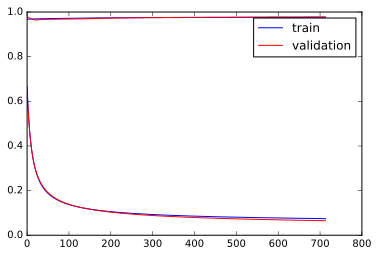

test_acc= 0.9655172
train_accuracy= 0.9767750075885228 validation_accuracy= 0.9800000190734863 train_loss function= 0.07436155847140721


In [7]:
#FOR PART 1
#for storing data
train_acc_log = np.zeros(len(trainData))
valid_acc_log = np.zeros(len(trainData))
valid_loss_log = np.zeros(len(trainData))
train_loss = np.zeros(len(trainData))

isAdam = False
train_loss,train_acc_log,valid_acc_log,valid_loss_log,test_acc_log= start_train(5000,0.001,True,isAdam,500) 
    
import matplotlib.pyplot as p 
p.plot(train_loss,'b-', label="train")
p.plot(train_acc_log,'b-')
p.plot(valid_acc_log,'r-',label ="validation")
p.plot(valid_loss_log,'r-')
p.legend(numpoints = 1)
p.show()
print("test_acc=",test_acc_log)
print("train_accuracy=",np.max(train_acc_log),"validation_accuracy=",np.max(valid_acc_log),"train_loss function=",np.min(train_loss))
#avrg_min_loss,avrg_max_acc

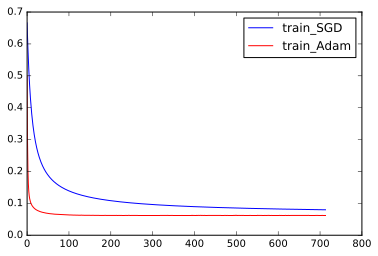

Adam_loss= 0.4986114374228886 SGD_Loss= 0.6660328422273908


In [8]:
#FOR PART 2
#for storing data

isAdam = False
SGD_loss,_,_,_,_= start_train(5000,0.001,False,isAdam,500) 
isAdam = True 
Adam_loss_log,_,_,_,_= start_train(5000,0.001,False,isAdam,500) 

import matplotlib.pyplot as p 
p.plot(SGD_loss,'b-', label="train_SGD")
p.plot(Adam_loss_log,'r-',label ="train_Adam")
p.legend(numpoints = 1)
p.show()
print("Adam_loss=",np.max(Adam_loss_log),"SGD_Loss=",np.max(SGD_loss))
#avrg_min_loss,avrg_max_acc

_,accuracy [0.0, 0.9517241]
[0.9517241]


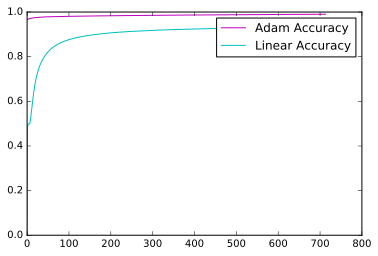

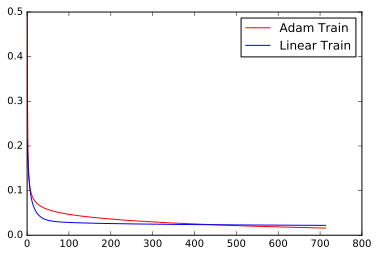

Adam_loss= 0.49679932424000334


In [9]:
#For Part 3

isAdam = True 
Adam_loss_log,Adam_acc_log,_,_,_= start_train(5000,0.001,True,isAdam,500) 
mse_loss_train, _,mse_acc_log = train_and_run_linear_reg(714,500,0.001,0, 1)

import matplotlib.pyplot as p 
p.plot(Adam_acc_log,'m-', label="Adam Accuracy")
p.plot(mse_acc_log,'c-', label="Linear Accuracy")
p.legend(numpoints = 1)
p.show() 
p.plot(Adam_loss_log,'r-',label ="Adam Train")
p.plot(mse_loss_train,'b-',label="Linear Train")
p.legend(numpoints = 1)
p.show()
print("Adam_loss=",np.max(Adam_loss_log))

In [10]:
""""""